In [1]:
import pybinding as pb
import numpy as np
import matplotlib.pyplot as plt
pb.pltutils.use_style()
%matplotlib inline
from pybinding.repository import graphene
from math import pi, sqrt

In [4]:
def model2(a, V_A, V_B, V_C):    # V_A: left potential. V_B: center area potential. V_C: right potential. 
    # 1. a should be odd numbers because if a is even, the model becomes a little unsymmetric.
    # 2. a should? not be three's multiple numbers because the brilluiin points(K and Gamma) switch.
    def mass_term(c, V_A, V_B):   # c determines the area potential is applied. b determines the potential amplitude.
        @pb.onsite_energy_modifier
        def potential(energy, x, y):
            energy[np.tan(np.pi/3)*x+y<-c] = V_A
            energy[np.tan(np.pi/3)*x+y>c] = V_B
            energy[(np.tan(np.pi/3)*x+y>-c)&(np.tan(np.pi/3)*x+y<c)] = V_C
            return energy
        return potential
    width = a*graphene.a  # nm
    b = a
    print ("the superlattice width is ", width, "nm")
    
    ###################################### model without potential ######################################
    global without_potential
    without_potential = pb.Model(graphene.monolayer(),
                    pb.primitive(a1=a, a2=b),
                    pb.translational_symmetry(a1=a*graphene.a, a2=b*graphene.a)
    )
    ######################################## model with potential ########################################
    with_potential = pb.Model(graphene.monolayer(),
                              pb.primitive(a1=a, a2=b),
                              pb.translational_symmetry(a1=a*graphene.a, a2=b*graphene.a),
                              mass_term(np.tan(np.pi/3)*0.5*width-0.4,V_A,V_B)   # for this condition, the potential area is suited for kagome lattice.
    )
    
    ######################################## Brillouin points setting ########################################
    a_cc = graphene.a_cc
    a2 = a*graphene.a_cc*sqrt(3)
    b2= b*graphene.a_cc*sqrt(3)
    Gamma = [0, 0]
    K1 = [-4*pi / (3*a2), 0]
    M = [0, 2*pi / (sqrt(3)*b2)]
    K2 = [2*pi / (3*a2), 2*pi / (b2*sqrt(3))]
    
    ############################## Superlattice and potential configuration ##############################
    
    global fig1
    fig1 = plt.figure(1, figsize=(13,13))
    plt.figure(1)
    plt.subplot(121, title ='Superlattice structure and potential configuration')
    with_potential.onsite_map.plot(cmap="coolwarm", site_radius=0.04, num_periods=1)
    pb.pltutils.colorbar(label="U (eV)")

    ##################################### Band stucture and density of state #####################################
    global fig2
    fig2 = plt.figure(2, figsize=(13,13))
    plt.figure(2, figsize=(13,13))
    plt.subplot(121)
    solver = pb.solver.lapack(without_potential)
    bands = solver.calc_bands(K1,Gamma,M,K2)
    bands.plot(color='b')
    ylim = 1.5
    step = 0.05*ylim
    plt.yticks(np.arange(-ylim,ylim,step))
    plt.ylim(-ylim,ylim)

In [1]:
import pybinding as pb
import numpy as np
import matplotlib.pyplot as plt
pb.pltutils.use_style()
%matplotlib inline
from pybinding.repository import graphene
from math import pi, sqrt

a_cc = 0.142
a = a_cc*np.sqrt(3)
def Lat_two_seg_AGNR(W1 = 10, W2 = 10, start_y_seg = 0,
               t1=graphene.t, t2=graphene.t, t_interface=graphene.t, 
               onsite=0, onsite2=0, onsite_inter=0):
    num_columns = W2
    global a_suplat
    a_suplat = a * (W1)
    total_number = W1*W2
    lat = pb.Lattice(a1 = [a*num_columns, 0],
                     a2 = [a*(W1)/4, a_cc*(W1)*3/4])
    a1 = [a*num_columns, 0]
    a2 = [a*(W1)/4, a_cc*(W1)*3/4]

    chr_up = []
    for j in range(0, num_columns):
        chr_up.append([])
        for i in range(0, W1 + start_y_seg):
            temp_up  = chr(65+j%26) + chr(65 + i%26)
            for k in range(0, i//26):
                temp_up  += chr(ord('+'))
                
            chr_up[j].append( temp_up)
    
    g = open("myPositions.xyz", "w")
    g.write(str(total_number)+"\n")
    g.write(str("Lattice=")+str('"') 
            + str(a1[0])+" "+str(a1[1])+" "+str(0)+" "+str(a2[0])+" "
            +str(a2[1])+" "+str(0)+" "+str('# type')+" "+str('"') +"\n")

    N_loop_start = start_y_seg
    N_loop_end = W1 + start_y_seg
    E_onsite_up = onsite
    for j in range(0, num_columns):     
        for i in range(N_loop_start, N_loop_end):
            if i%2 == 0:# and (i != start_y_seg or j != 0) and (i != N_loop_end-1 or j != num_columns-1):
                lat.add_sublattices(
                    (chr_up[j][i],  [j*a + a/2*(i/2),      a_cc*1.5*i/2],        E_onsite_up))
                g.write("C1" + " " + str(j*a + a/2*(i/2))+ " " + str(a_cc*1.5*i/2) 
                        + " " + str(0) +  "\n")
            elif i%2 == 1:# and (i != start_y_seg or j != 0) and (i != N_loop_end-1 or j != num_columns-1):
                lat.add_sublattices(
                    (chr_up[j][i],  [j*a + a/2*(int(i/2)), a_cc*1.5*int(i/2) + a_cc], E_onsite_up))
                g.write("C2" + " " + str(j*a + a/2*(int(i/2)))+ " " + str(a_cc*1.5*int(i/2)+ a_cc)
                        + " " + str(0) + "\n")

    #return lat
    g.close()


    N_loop_start = start_y_seg
    N_loop_end = W1 + start_y_seg
    t = t1
    for j in range(0, num_columns):
        for i in range(N_loop_start, N_loop_end):
            #print('connection', i)
            if i != N_loop_end - 1:# and (i != start_y_seg or j != 0) and (i != (N_loop_end-1)-1 or j != num_columns-1):
                lat.add_hoppings(([0,  0], chr_up[j][i],  chr_up[j][i+1],   t))

            if i%2 == 0 and i>=1 and j<= (num_columns-1) -1 and (i != start_y_seg or j != 0) and (i != N_loop_end-1 or j <= (num_columns-1)-1):# and i  <= N_loop_end:
                #print(j,'th column bonding with j+1 th column')
                lat.add_hoppings(([0,  0], chr_up[j][i],  chr_up[j+1][i-1], t))
           # if i%2 == 0 and i>=1 and j<= (num_columns-1) -1 and (i != start_y_seg or j != 0) and (i != N_loop_end-1 or j <= (num_columns-1)-1):# and i  <= N_loop_end:
                #print(j,'th column bonding with j+1 th column')
           #     lat.add_hoppings(([0,  0], chr_up[j][i],  chr_up[j+1][i-1], t_interface))
            
            if i%2 == 0 and j == num_columns-1 and i != start_y_seg:# and (i != start_y_seg or j != 0) and (i != (N_loop_end-1)-1 or j != num_columns-1):
                lat.add_hoppings(([1,  0], chr_up[j][i],  chr_up[0][i-1],   t_interface))
            if i == N_loop_end -1:
                if j != 0:
                    lat.add_hoppings(([0,  1], chr_up[j][i],  chr_up[j-1][start_y_seg],   t_interface))
                lat.add_hoppings(([0,  1], chr_up[j][i],  chr_up[j][start_y_seg],   t_interface))
            if i == start_y_seg and j == num_columns-1:
                print('vertext connected')
                lat.add_hoppings(([1,  -1], chr_up[j][i],  chr_up[0][N_loop_end -1],   t_interface))
    return lat


vertext connected


"\nplt.figure(2)\nsolver = pb.solver.lapack(model_97ANGR)\nbands = solver.calc_bands(K1,Gamma,M,K2)\nplt.subplot(122)\nbands.plot(color='r') #marker='^', markersize= 5)\nylim = 1.5\nstep = 0.05*ylim\nplt.yticks(np.arange(-ylim,ylim,step))\nplt.ylim(-ylim,ylim)\nplt.show()\n\n"

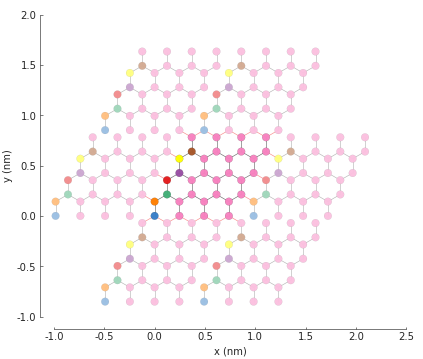

In [4]:
    i = 4
    
    #model2(i,0,0,0)  # a: need to put odd number, V_A, V_B
    N = i
    lat_ANGR = Lat_two_seg_AGNR(W1=2*N, W2=N, start_y_seg = 0,
                                      t1=-2.8,
                                      onsite=0, onsite2=0)
    plt.figure(figsize=(15,10))
    plt.subplot(122)
    
    model_97ANGR = pb.Model(lat_ANGR,
                            #pb.primitive(a1=2, a2=2),
                           pb.translational_symmetry(a1 = i*graphene.a,a2=i*graphene.a))
    model_97ANGR.plot()
    a = graphene.a
    a_cc = graphene.a_cc


    a2 = i*graphene.a_cc*sqrt(3)
    b2= i*graphene.a_cc*sqrt(3)
    Gamma = [0, 0]
    K1 = [-4*pi / (3*a2), 0]
    M = [0, 2*pi / (sqrt(3)*b2)]
    K2 = [2*pi / (3*a2), 2*pi / (b2*sqrt(3))]
"""
    plt.figure(2)
    solver = pb.solver.lapack(model_97ANGR)
    bands = solver.calc_bands(K1,Gamma,M,K2)
    plt.subplot(122)
    bands.plot(color='r') #marker='^', markersize= 5)
    ylim = 1.5
    step = 0.05*ylim
    plt.yticks(np.arange(-ylim,ylim,step))
    plt.ylim(-ylim,ylim)
    plt.show()
    
"""

In [26]:
a_cc = 0.142
a = a_cc*np.sqrt(3)
def Lat_two_seg_AGNR(W1 = 10, W2 = 10, start_y_seg = 0,
               t1=graphene.t, t2=graphene.t, t_interface=graphene.t, 
               onsite=0, onsite2=0, onsite_inter=0):
    num_columns = W2
    global a_suplat
    a_suplat = a * (W1)
    
    lat = pb.Lattice(a1 = [a*num_columns, 0],
                     a2 = [a*(W1)/4, a_cc*(W1)*3/4])

    chr_up = []
    for j in range(0, num_columns):
        chr_up.append([])
        for i in range(0, W1 + start_y_seg):
            temp_up  = chr(65+j%26) + chr(65 + i%26)
            for k in range(0, i//26):
                temp_up  += chr(ord('+'))
                
            chr_up[j].append( temp_up)
    
    
    N_loop_start = start_y_seg
    N_loop_end = W1 + start_y_seg
    E_onsite_up = onsite
    for j in range(0, num_columns):     
        for i in range(N_loop_start, N_loop_end):
            if i%2 == 0:# and (i != start_y_seg or j != 0) and (i != N_loop_end-1 or j != num_columns-1):
                lat.add_sublattices(
                    (chr_up[j][i],  [j*a + a/2*(i/2),      a_cc*1.5*i/2],        E_onsite_up))
            elif i%2 == 1:# and (i != start_y_seg or j != 0) and (i != N_loop_end-1 or j != num_columns-1):
                lat.add_sublattices(
                    (chr_up[j][i],  [j*a + a/2*(int(i/2)), a_cc*1.5*int(i/2) + a_cc], E_onsite_up))
    #return lat


    N_loop_start = start_y_seg
    N_loop_end = W1 + start_y_seg
    t = t1
    for j in range(0, num_columns):
        for i in range(N_loop_start, N_loop_end):
            #print('connection', i)
            if i != N_loop_end - 1:# and (i != start_y_seg or j != 0) and (i != (N_loop_end-1)-1 or j != num_columns-1):
                lat.add_hoppings(([0,  0], chr_up[j][i],  chr_up[j][i+1],   t))

            if i%2 == 0 and i>=1 and j<= (num_columns-1) -1 and (i != start_y_seg or j != 0) and (i != N_loop_end-1 or j <= (num_columns-1)-1):# and i  <= N_loop_end:
                #print(j,'th column bonding with j+1 th column')
                lat.add_hoppings(([0,  0], chr_up[j][i],  chr_up[j+1][i-1], t))
           # if i%2 == 0 and i>=1 and j<= (num_columns-1) -1 and (i != start_y_seg or j != 0) and (i != N_loop_end-1 or j <= (num_columns-1)-1):# and i  <= N_loop_end:
                #print(j,'th column bonding with j+1 th column')
           #     lat.add_hoppings(([0,  0], chr_up[j][i],  chr_up[j+1][i-1], t_interface))
            
            if i%2 == 0 and j == num_columns-1 and i != start_y_seg:# and (i != start_y_seg or j != 0) and (i != (N_loop_end-1)-1 or j != num_columns-1):
                lat.add_hoppings(([1,  0], chr_up[j][i],  chr_up[0][i-1],   t_interface))
            if i == N_loop_end -1:
                if j != 0:
                    lat.add_hoppings(([0,  1], chr_up[j][i],  chr_up[j-1][start_y_seg],   t_interface))
                lat.add_hoppings(([0,  1], chr_up[j][i],  chr_up[j][start_y_seg],   t_interface))
            if i == start_y_seg and j == num_columns-1:
                print('vertext connected')
                lat.add_hoppings(([1,  -1], chr_up[j][i],  chr_up[0][N_loop_end -1],   t_interface))
    return lat


vertext connected


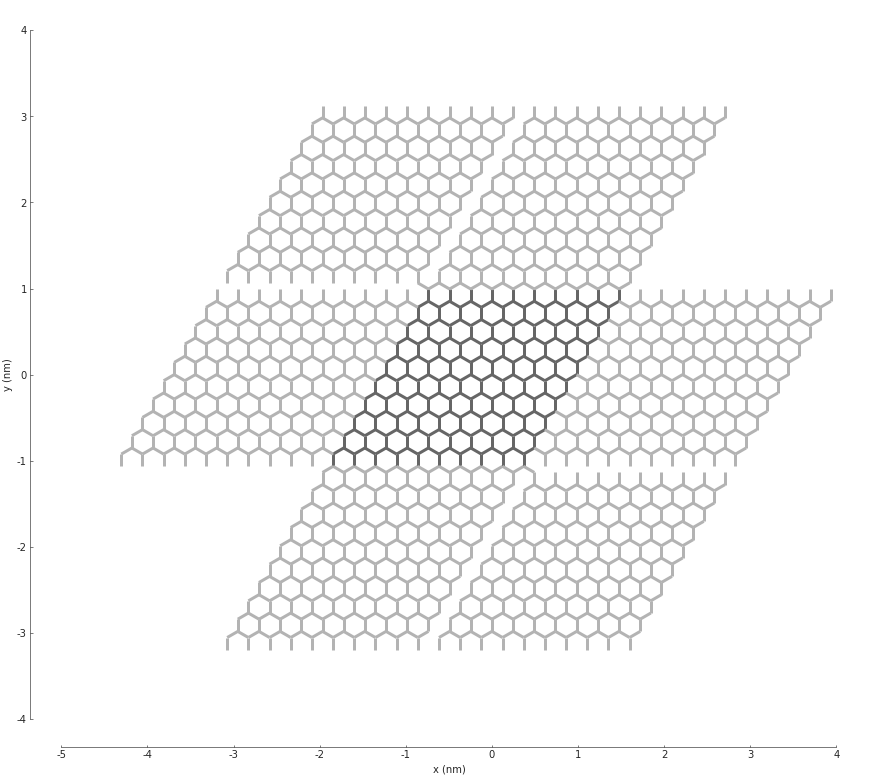

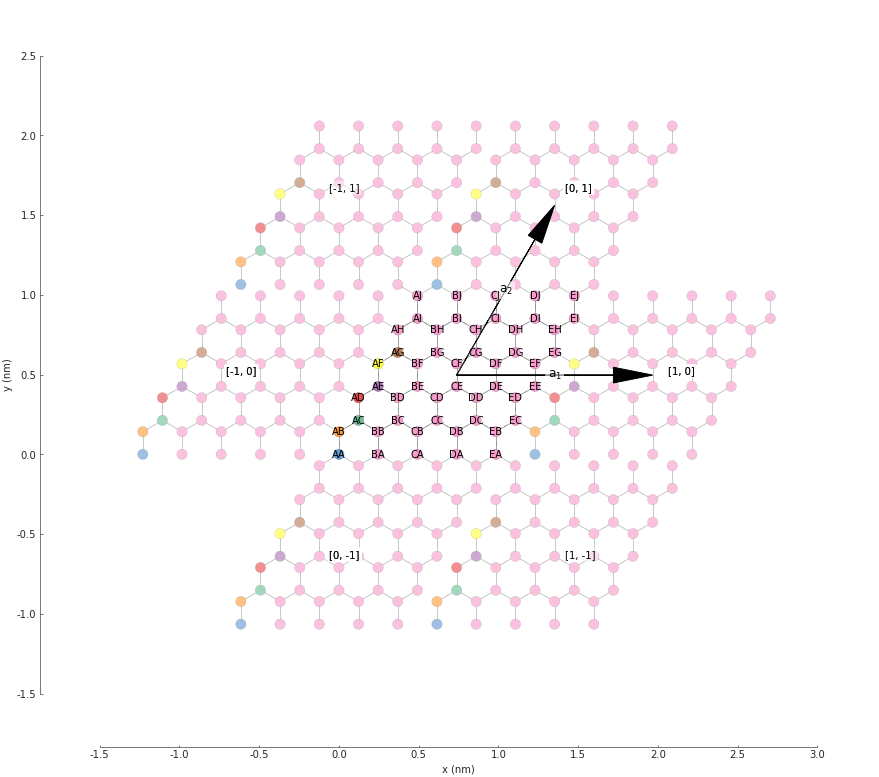

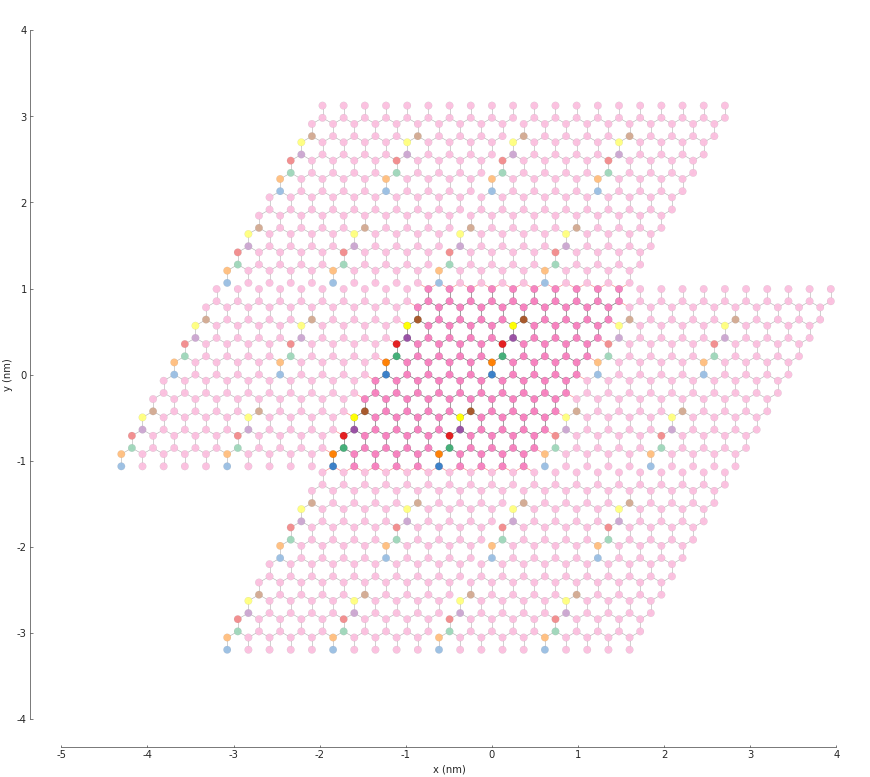

In [40]:
N = 5
i = 5
lat_ANGR = Lat_two_seg_AGNR(W1=2*N, W2=N, start_y_seg = 0,
                                  t1=-2.8,
                                  onsite=0, onsite2=0)
model_97ANGR = pb.Model(lat_ANGR,
                        pb.primitive(a1=2, a2=2),
                            pb.translational_symmetry(a1 = 2*i*graphene.a,a2=2*i*graphene.a))
plt.figure(figsize=(15,15))
model_97ANGR.plot(site={"radius": 0} , hopping ={'width':5, 'cmap': 'auto'})
plt.figure(figsize=(15,15))
lat_ANGR.plot()
plt.show()
plt.figure(figsize=(15,15))
model_97ANGR.plot()

In [ ]:
plt.figure(1, figsize=(15,10))
without_potential.plot()

the superlattice width is  1.4757 nm


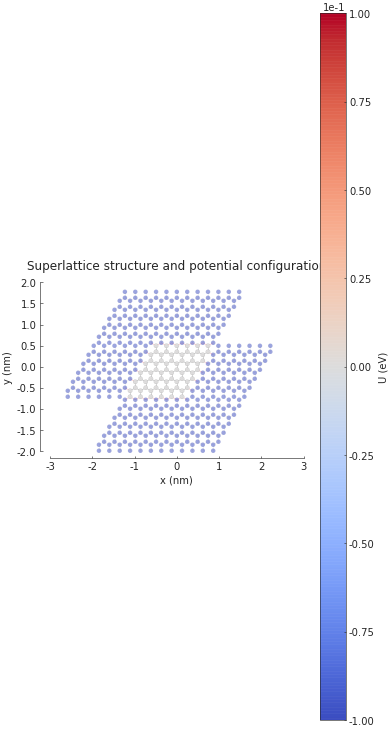

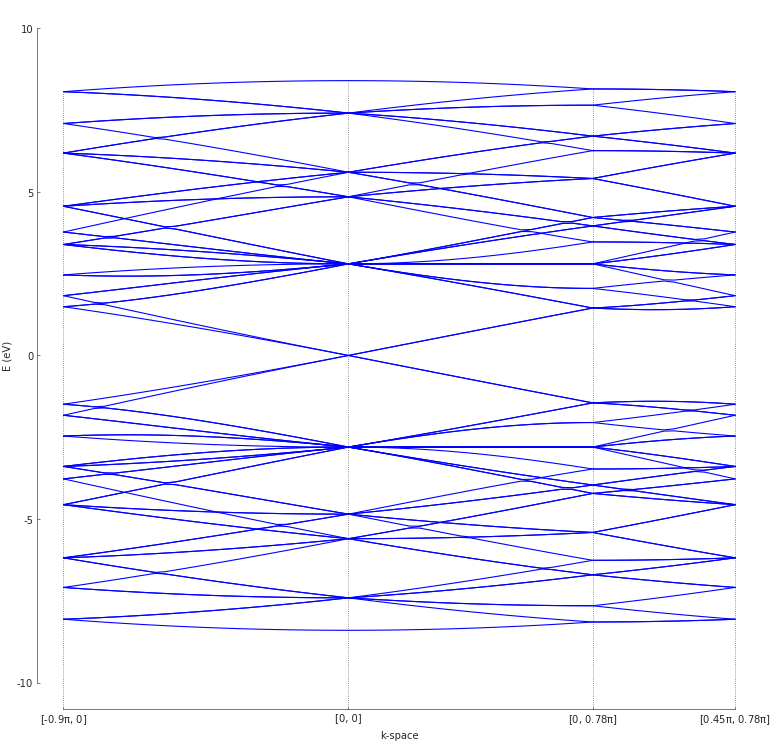

In [200]:
model2(6,0,0,0)
plt.show()